# Evironment initialization

In [2]:
source("./initialization.r")

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: DT
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: magick
Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading re

# Data inspection

In [3]:
bugsData <- read.table("bugs.csv", header=TRUE, sep=";", stringsAsFactors=FALSE)

In [4]:
classes <- sapply(bugsData, class)
classes
dim(bugsData)
dim(na.omit(bugsData))

CBO                 DIT               FanIn              FanOut 
          "integer"           "integer"           "integer"           "integer" 
               LCOM                 NOC                 RFC                 WMC 
          "integer"           "integer"           "integer"           "integer" 
                LOC          Attributes AttributesInherited             Methods 
          "integer"           "integer"           "integer"           "integer" 
   MethodsInherited                Bugs 
          "integer"           "integer"

[1] 997  14

[1] 997  14

In [5]:
summary(bugsData)

      CBO              DIT            FanIn             FanOut      
 Min.   :  0.00   Min.   :1.000   Min.   :  0.000   Min.   : 0.000  
 1st Qu.:  3.00   1st Qu.:1.000   1st Qu.:  1.000   1st Qu.: 2.000  
 Median :  7.00   Median :2.000   Median :  2.000   Median : 4.000  
 Mean   : 12.22   Mean   :2.727   Mean   :  5.368   Mean   : 7.395  
 3rd Qu.: 14.00   3rd Qu.:4.000   3rd Qu.:  4.000   3rd Qu.:10.000  
 Max.   :156.00   Max.   :8.000   Max.   :137.000   Max.   :93.000  
      LCOM              NOC               RFC               WMC         
 Min.   :    0.0   Min.   : 0.0000   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:    6.0   1st Qu.: 0.0000   1st Qu.:  12.00   1st Qu.:   8.00  
 Median :   28.0   Median : 0.0000   Median :  30.00   Median :  20.00  
 Mean   :  364.7   Mean   : 0.7121   Mean   :  76.87   Mean   :  58.38  
 3rd Qu.:   91.0   3rd Qu.: 0.0000   3rd Qu.:  70.00   3rd Qu.:  50.00  
 Max.   :81003.0   Max.   :26.0000   Max.   :2603.00   Max.   :1680.00  
      

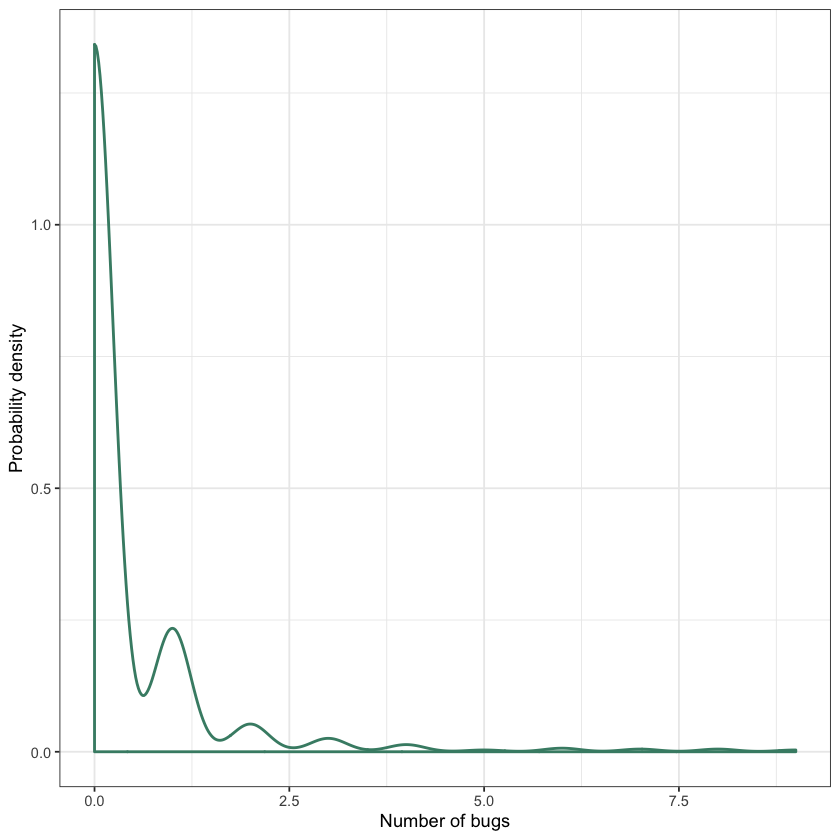

In [6]:
 ggplot(data=bugsData, aes(x=Bugs)) +
  geom_density(color = "aquamarine4", lwd = 0.8) +
  labs(x = "Number of bugs", y = "Probability density") +
  theme_bw()

# Statistical analysis
Correletion "matrix"

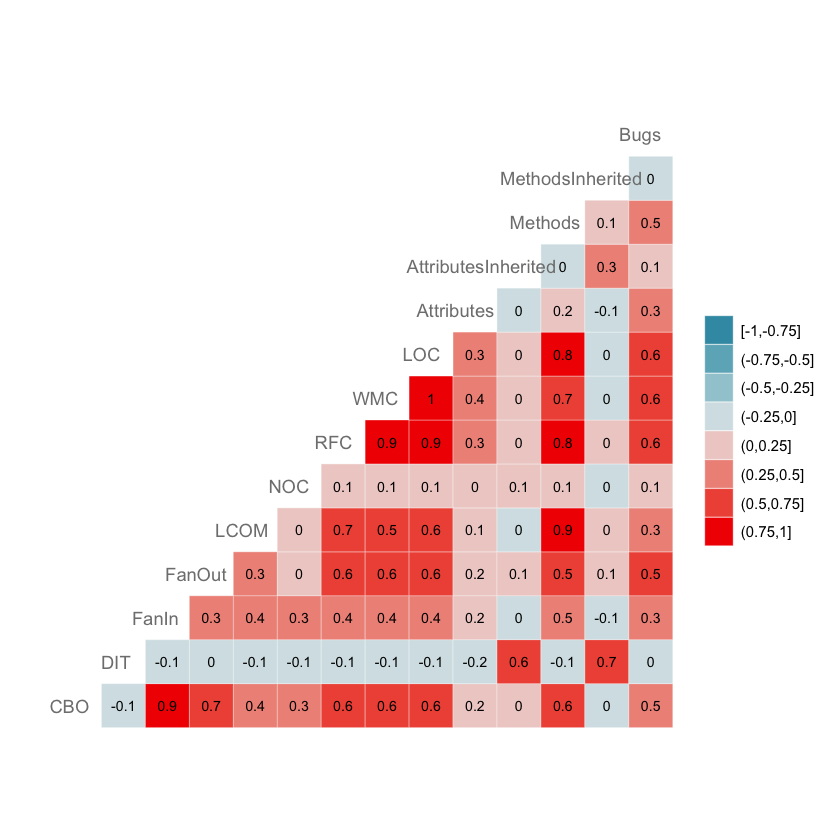

In [7]:
ggcorr(
    bugsData,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

## Data distribution plotted
Don't know how to interpret this...

In [8]:
numericChart <- function(colName, colorCol) {
  ggplot(bugsData, aes(x = Bugs, y = bugsData[[colName]])) +
    geom_jitter(size = 1.5, stat = "identity", colour=colorCol) +
    labs(x = "Bugs", y = colName) +
    theme_bw()
}

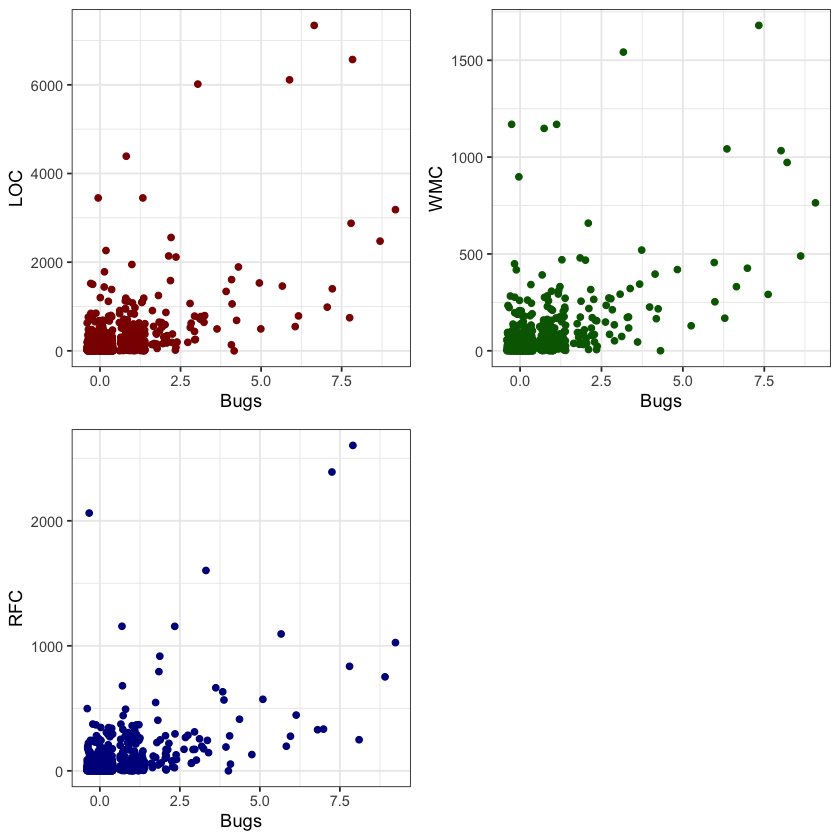

In [9]:
plot_grid(
  numericChart("LOC", "darkred"),
  numericChart("WMC", "darkgreen"),
  numericChart("RFC", "darkblue")
)

# Prepare prediction environment

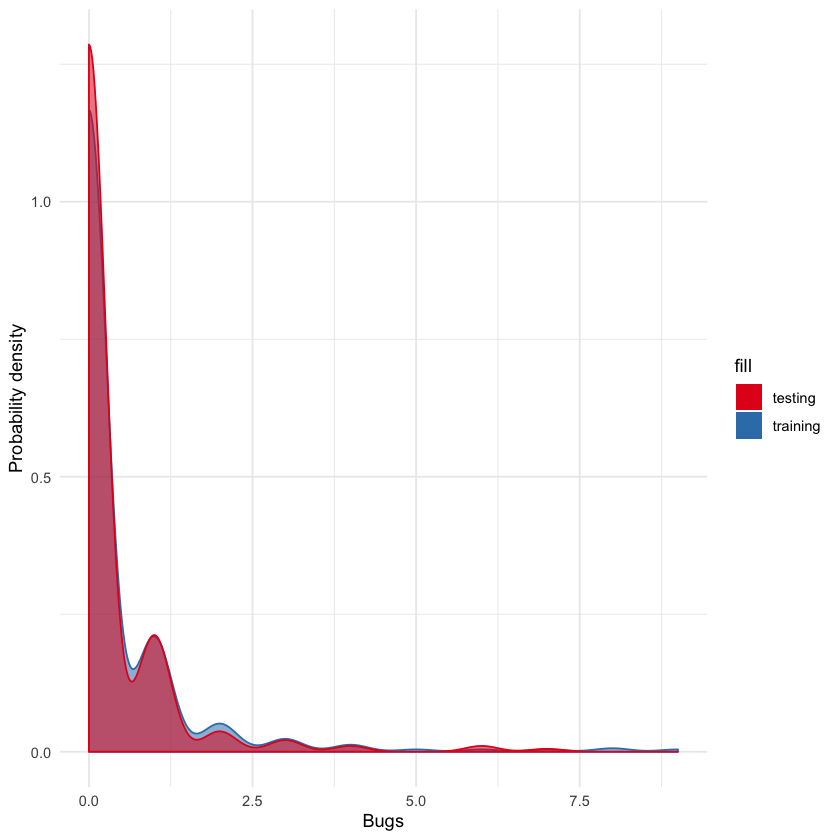

In [10]:
inTrain <- createDataPartition(bugsData$Bugs, p=0.7, list=FALSE)
training <- bugsData[inTrain,]
testing <- bugsData[-inTrain,]

ggplot(mapping=aes(alpha=0.2)) + 
 geom_density(aes(Bugs, fill="training", color="training"), training) + 
 geom_density(aes(Bugs, fill="testing", color="testing"), testing) + 
 theme_minimal() +
  xlab("Bugs") +
  ylab("Probability density") +
  scale_fill_brewer(palette="Set1") +
  scale_color_brewer(palette="Set1") + 
  guides(color = FALSE, alpha = FALSE, fill=guide_legend(override.aes = list(color = NA)))

In [11]:
X_train = select(training, -Bugs)
y_train = training$Bugs
X_test = select(testing, -Bugs)
y_test = testing$Bugs

In [12]:
trcontrol = trainControl(
  method = "cv",
  number = 10,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

In [13]:
evaluateStats <- function(model) {
  predicted = predict(model, X_test)
  residuals = y_test - predicted
  
  RMSE <- round(sqrt(mean(residuals^2)), 3)
  
  y_testMean = mean(y_test)
  totalSS =  sum((y_test - y_testMean)^2 )
  residualSS =  sum(residuals^2)
  rSquare  =  round(1 - (residualSS/totalSS), 3)
  
  list(RMSE = RMSE, rSquare = rSquare)
}

In [14]:
predictionChart <- function(model) {
  predicted = predict(model, X_test)
  mergedResults = as.data.frame(cbind(predicted = predicted, observed = y_test))
  # Plot predictions vs test data
  ggplot(mergedResults, aes(y = predicted, x = observed)) +
    geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm) +
    ylab("Predicted number of bugs") +
    xlab("Real number of bugs") + 
    theme(
      axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
      axis.title.x = element_text(size=14), axis.title.y = element_text(size=14)
    )
}

In [15]:
importancePlot <- function(model) ggplot(varImp(model))

# kNN without Preprocessing

In [16]:
knnGrid <- expand.grid(k = seq(1, 25, by = 2))

In [17]:
knnModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid
)

In [18]:
knnModel

k-Nearest Neighbors 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 629, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.9601611  0.3150079  0.3931884
   3  0.8829554  0.3604143  0.3837819
   5  0.8795946  0.3759584  0.3988875
   7  0.8793489  0.3814459  0.4014947
   9  0.8783016  0.3792925  0.4049413
  11  0.8631682  0.3923290  0.4029466
  13  0.8624331  0.3964993  0.4049752
  15  0.8643656  0.3905176  0.4042965
  17  0.8566519  0.4009172  0.4010665
  19  0.8588850  0.3986943  0.4007061
  21  0.8576121  0.4076358  0.3990857
  23  0.8658259  0.3971095  0.4027625
  25  0.8704266  0.3921622  0.4056561

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 17.

In [19]:
knnModel$bestTune
knnStats <- evaluateStats(knnModel)
knnStats

,k
,<dbl>
9,17


$RMSE
[1] 0.726

$rSquare
[1] 0.31

##### knnStats <- evaluateStats(knnModel)
knnStats

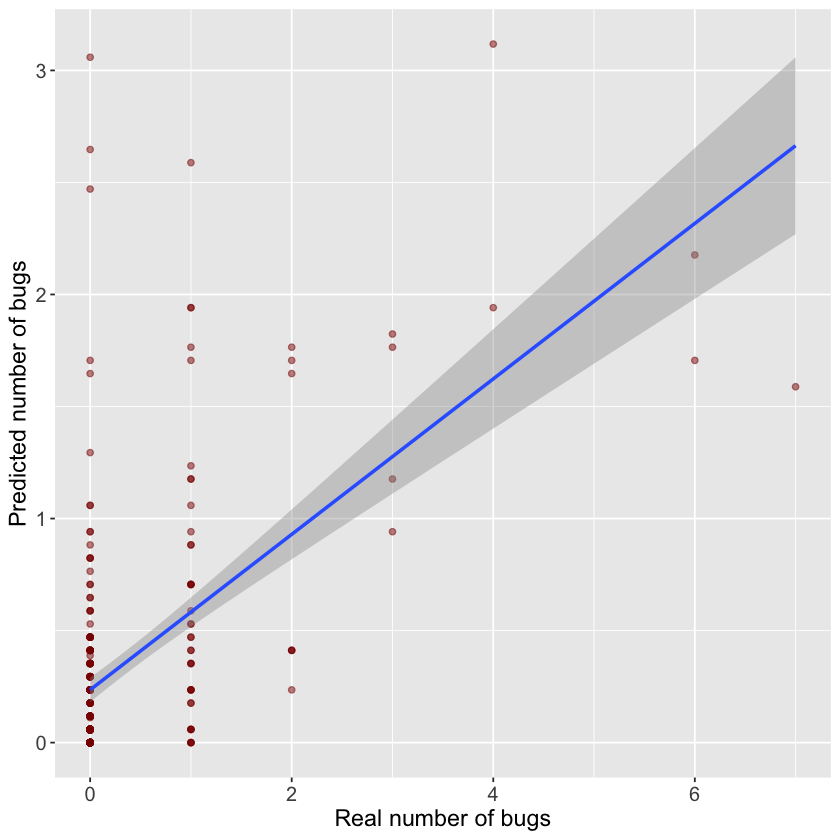

In [20]:
predictionChart(knnModel)

# kNN with Preprocessing

In [21]:
knnPreModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid,
  preProcess = c("center", "scale")
)

In [22]:
knnPreModel

k-Nearest Neighbors 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  1.1110315  0.2337919  0.4312629
   3  0.9897522  0.2479433  0.4126622
   5  0.9182531  0.3010976  0.3985362
   7  0.8735214  0.3574528  0.3860900
   9  0.8546614  0.3764351  0.3887466
  11  0.8465719  0.3857048  0.3876368
  13  0.8512078  0.3906381  0.3905497
  15  0.8543840  0.3926405  0.3925642
  17  0.8631234  0.3868694  0.3960383
  19  0.8671264  0.3810937  0.3985816
  21  0.8715443  0.3816981  0.4002719
  23  0.8787554  0.3749737  0.4020283
  25  0.8866052  0.3672288  0.4043527

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 11.

In [23]:
knnPreModel$bestTune

,k
,<dbl>
6,11


In [24]:
knnPreStats <- evaluateStats(knnPreModel)
knnPreStats

$RMSE
[1] 0.746

$rSquare
[1] 0.271

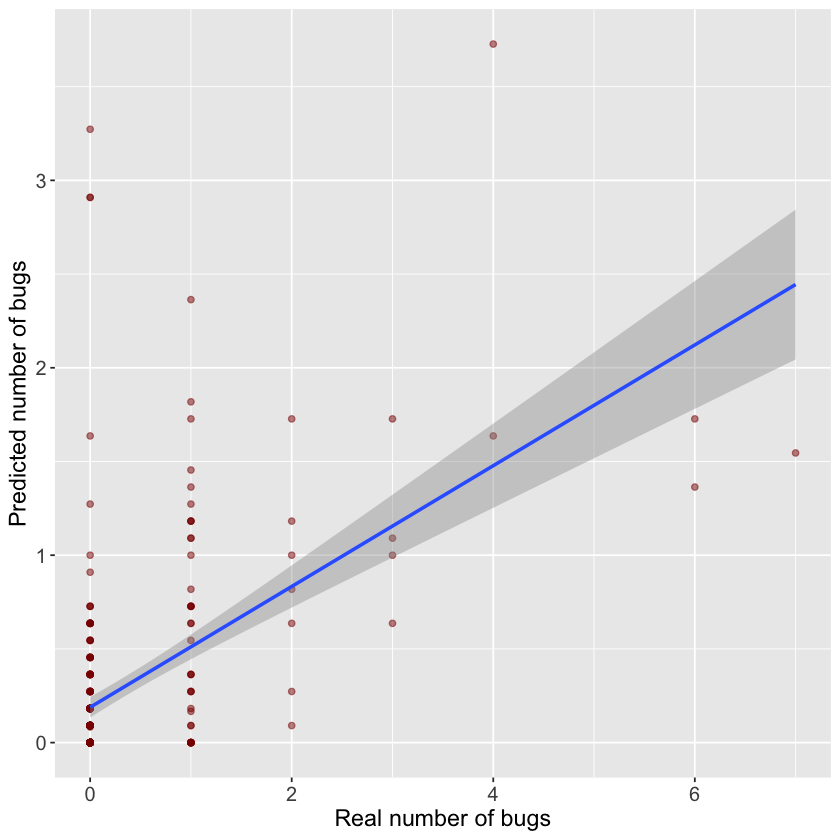

In [25]:
predictionChart(knnPreModel)

# Random Forest Regression

In [26]:
rfGrid <- expand.grid(.mtry=ncol(X_train)/3)

In [27]:
rfModel <- train(
  X_train, y_train,
  method = "rf",
  trControl = trcontrol,
  tuneGrid = rfGrid,
  importance = TRUE
)

In [28]:
rfModel

Random Forest 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 629, 628, 629, 628, 628, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8595395  0.4261077  0.4208862

Tuning parameter 'mtry' was held constant at a value of 4.333333

In [29]:
rfModel$bestTune

mtry
<dbl>
4.333333


In [30]:
rfStats <- evaluateStats(rfModel)
rfStats

$RMSE
[1] 0.752

$rSquare
[1] 0.259

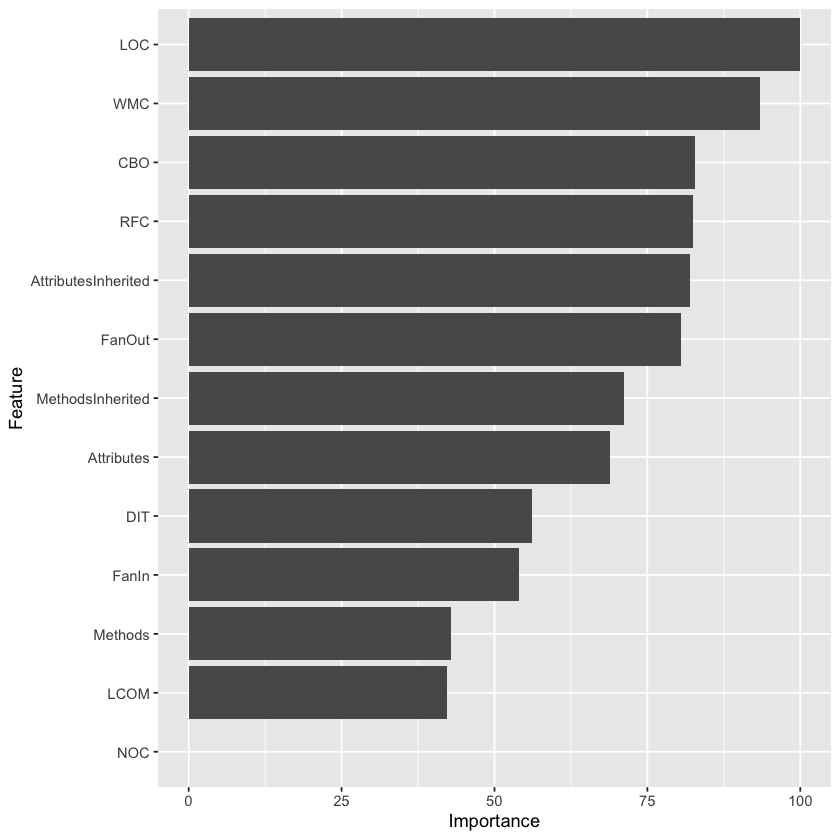

In [31]:
importancePlot(rfModel)

# Extreme Gradient Boosting regression

In [32]:
xgbGrid <- expand.grid(
    nrounds = c(100,200), 
    max_depth = c(10, 15, 20, 25),
    colsample_bytree = seq(0.5, 0.9, length.out = 5),
    eta = 0.1,
    gamma=0,
    min_child_weight = 1,
    subsample = 1
  )

In [33]:
xgbModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)

In [36]:
xgbModel

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8898867  0.3775024  0.4270575
  10         0.5               200      0.8905914  0.3769755  0.4278259
  10         0.6               100      0.8969452  0.3681897  0.4221017
  10         0.6               200      0.8971113  0.3684032  0.4223535
  10         0.7               100      0.9124844  0.3503759  0.4244964
  10         0.7               200      0.9129505  0.3500249  0.4247938
  10         0.8               100      0.9181521  0.3512107  0.4213564
  10         0.8               200      0.9185492  0.3512472  0.4217109
  10         0.9               100      0.9520986  0.3204612  0.4284822
  10         0.9               200      0.9522027  0.3207756  0.4284628
  15         0.5 

In [37]:
xgbModel$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,100,20,0.1,0,0.5,1,1


In [38]:
xgbStats <- evaluateStats(xgbModel)
xgbStats

$RMSE
[1] 0.798

$rSquare
[1] 0.165

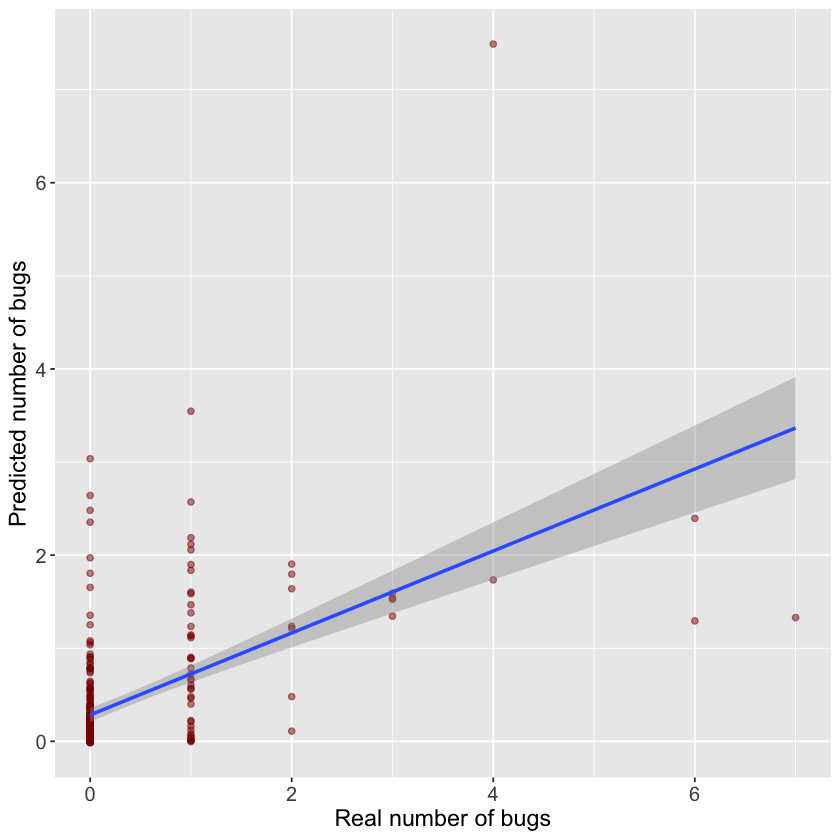

In [39]:
predictionChart(xgbModel)

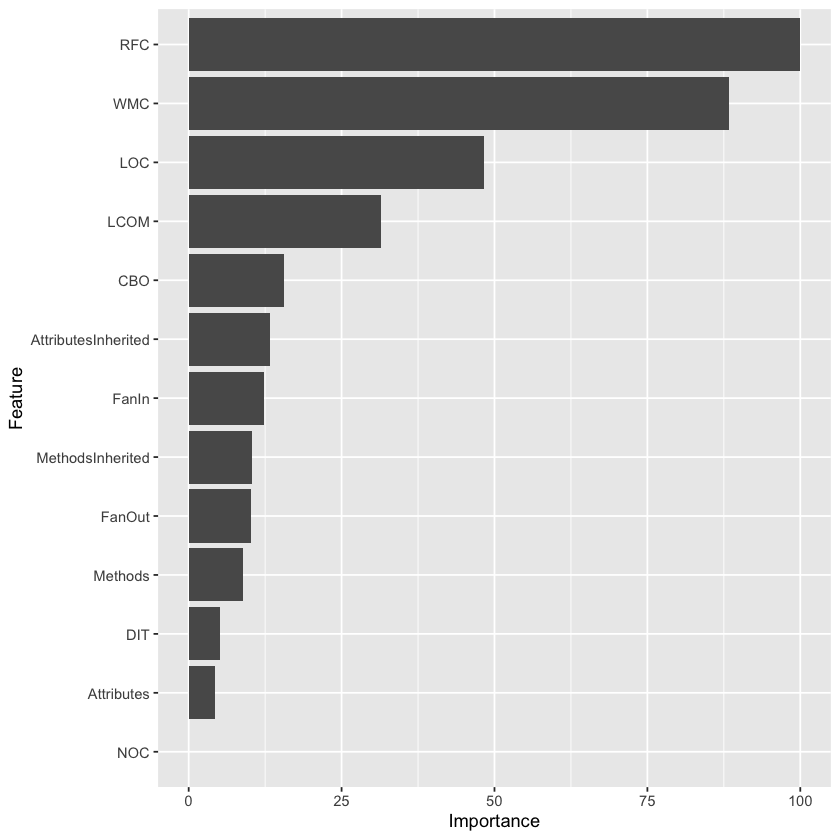

In [40]:
importancePlot(xgbModel)

In [41]:
xgbPreModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree",
  preProcess = c("center", "scale")
)

In [42]:
xgbPreModel

eXtreme Gradient Boosting 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8377464  0.4242739  0.4046140
  10         0.5               200      0.8381507  0.4242313  0.4049667
  10         0.6               100      0.8793881  0.3774892  0.4175277
  10         0.6               200      0.8796041  0.3775956  0.4175385
  10         0.7               100      0.8891448  0.3679789  0.4166799
  10         0.7               200      0.8894802  0.3680964  0.4169136
  10         0.8               100      0.9466178  0.3496045  0.4249864
  10         0.8               200      0.9470641  0.3499382  0.4254958
  10         0.9               100      0.9364910  0.3302226  0.4309303
  10         0.9               200      0.9367627  0.3307362  0

In [43]:
xgbPreModel$bestTune

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,10,0.1,0,0.5,1,1


In [44]:
xgbPreStats <- evaluateStats(xgbPreModel)
xgbPreStats

$RMSE
[1] 0.796

$rSquare
[1] 0.169

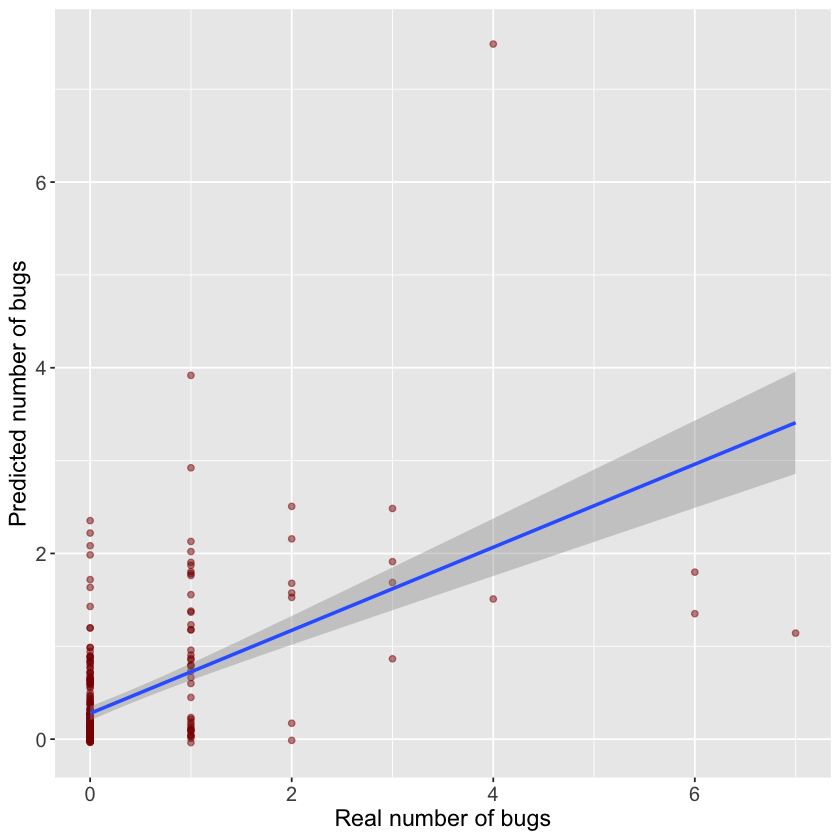

In [45]:
predictionChart(xgbPreModel)

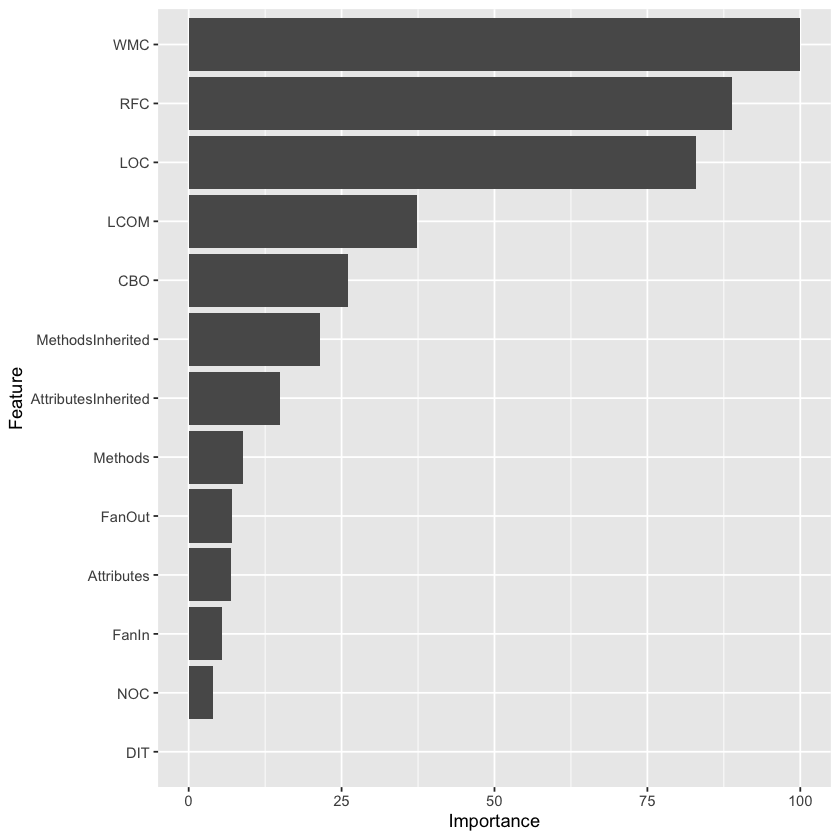

In [46]:
importancePlot(xgbPreModel)

# Neural Net predition using 'caret' library

In [47]:
nnetGrid <-  expand.grid(size = seq(from = 1, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 0.5, by = 0.1))

In [48]:
nnetModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid= nnetGrid,
  method = "nnet",
  preProcess = c("center", "scale")
)

# weights:  16
initial  value 818.097534 
iter  10 value 681.488396
iter  20 value 667.313610
iter  30 value 660.590500
iter  40 value 659.959741
iter  50 value 659.914824
iter  50 value 659.914822
iter  50 value 659.914822
final  value 659.914822 
converged
# weights:  31
initial  value 839.383367 
iter  10 value 686.347186
iter  20 value 659.949798
iter  30 value 656.468519
iter  40 value 655.204079
iter  50 value 652.738866
iter  60 value 651.943304
iter  70 value 650.079843
iter  80 value 648.252999
iter  90 value 644.605439
iter 100 value 644.308211
final  value 644.308211 
stopped after 100 iterations
# weights:  46
initial  value 816.844869 
iter  10 value 666.901002
iter  20 value 659.970031
iter  30 value 655.057835
iter  40 value 650.766085
iter  50 value 645.202305
iter  60 value 643.718140
iter  70 value 643.280291
iter  80 value 643.274617
final  value 643.274603 
converged
# weights:  61
initial  value 869.259917 
iter  10 value 671.497279
iter  20 value 661.813526
iter  

initial  value 845.628316 
iter  10 value 697.771159
iter  20 value 664.657323
iter  30 value 661.529501
iter  40 value 660.733537
iter  50 value 660.126745
iter  60 value 660.026837
iter  70 value 660.004530
iter  80 value 659.999115
final  value 659.999022 
converged
# weights:  136
initial  value 769.674683 
iter  10 value 691.682690
iter  20 value 666.217500
iter  30 value 661.724555
iter  40 value 660.551779
iter  50 value 659.818301
iter  60 value 659.671083
iter  70 value 659.529891
iter  80 value 659.502783
iter  90 value 659.499666
final  value 659.499624 
converged
# weights:  151
initial  value 823.400072 
iter  10 value 672.464501
iter  20 value 662.755065
iter  30 value 661.403530
iter  40 value 660.868114
iter  50 value 660.775684
iter  60 value 660.749429
iter  70 value 660.741960
final  value 660.741141 
converged
# weights:  16
initial  value 821.706039 
iter  10 value 693.653345
iter  20 value 678.036769
iter  30 value 677.540004
iter  30 value 677.539998
iter  30 val

initial  value 836.323750 
iter  10 value 593.858413
iter  20 value 581.152011
iter  30 value 573.887274
iter  40 value 572.392098
iter  50 value 571.063765
iter  60 value 570.431425
iter  70 value 570.120826
iter  80 value 569.960213
iter  90 value 569.887651
iter 100 value 569.623785
final  value 569.623785 
stopped after 100 iterations
# weights:  16
initial  value 738.539463 
iter  10 value 636.006209
iter  20 value 608.311657
iter  30 value 604.090644
final  value 604.085704 
converged
# weights:  31
initial  value 758.965750 
iter  10 value 640.976772
iter  20 value 600.665754
iter  30 value 596.039762
iter  40 value 595.433691
iter  50 value 595.090973
iter  60 value 595.058319
final  value 595.056897 
converged
# weights:  46
initial  value 821.131443 
iter  10 value 641.738855
iter  20 value 606.119890
iter  30 value 595.617696
iter  40 value 593.785397
iter  50 value 593.012849
iter  60 value 592.816469
iter  70 value 592.813718
final  value 592.813630 
converged
# weights:  

initial  value 724.946787 
iter  10 value 638.567896
iter  20 value 618.988853
final  value 618.830280 
converged
# weights:  31
initial  value 773.283427 
iter  10 value 631.377183
iter  20 value 615.143082
iter  30 value 608.847832
iter  40 value 608.411829
final  value 608.409050 
converged
# weights:  46
initial  value 725.944939 
iter  10 value 613.202518
iter  20 value 607.066063
iter  30 value 606.449037
final  value 606.415119 
converged
# weights:  61
initial  value 724.763810 
iter  10 value 639.790198
iter  20 value 606.972087
iter  30 value 605.608751
iter  40 value 605.567618
final  value 605.566992 
converged
# weights:  76
initial  value 750.276983 
iter  10 value 623.966237
iter  20 value 608.177681
iter  30 value 606.070137
iter  40 value 605.947379
iter  50 value 605.931501
iter  60 value 605.928906
final  value 605.928696 
converged
# weights:  91
initial  value 779.977611 
iter  10 value 617.396701
iter  20 value 605.774235
iter  30 value 604.211044
iter  40 value 6

initial  value 760.051863 
iter  10 value 609.233636
iter  20 value 601.527304
final  value 601.463196 
converged
# weights:  31
initial  value 767.017989 
iter  10 value 604.072805
iter  20 value 599.168499
iter  30 value 597.793578
iter  40 value 597.586407
final  value 597.578531 
converged
# weights:  46
initial  value 738.344023 
iter  10 value 626.341828
iter  20 value 601.072079
iter  30 value 596.661661
iter  40 value 595.483691
iter  50 value 595.421731
iter  60 value 595.415992
iter  70 value 595.410492
iter  80 value 595.394909
final  value 595.394127 
converged
# weights:  61
initial  value 774.842650 
iter  10 value 610.779712
iter  20 value 596.211876
iter  30 value 593.506977
iter  40 value 593.249706
iter  50 value 593.175566
iter  60 value 593.088112
iter  70 value 593.081717
final  value 593.081684 
converged
# weights:  76
initial  value 767.914988 
iter  10 value 620.800385
iter  20 value 595.418377
iter  30 value 592.622809
iter  40 value 592.360193
iter  50 value 

initial  value 779.906909 
iter  10 value 666.045640
iter  20 value 644.469773
iter  30 value 635.082927
iter  40 value 633.388322
iter  50 value 631.763289
iter  60 value 630.970964
iter  70 value 630.164793
iter  80 value 629.935824
iter  90 value 629.918341
iter 100 value 629.906512
final  value 629.906512 
stopped after 100 iterations
# weights:  91
initial  value 875.761151 
iter  10 value 683.614628
iter  20 value 651.116809
iter  30 value 634.382440
iter  40 value 632.094103
iter  50 value 630.572551
iter  60 value 629.609962
iter  70 value 629.389540
iter  80 value 629.342647
iter  90 value 629.328755
iter 100 value 629.323973
final  value 629.323973 
stopped after 100 iterations
# weights:  106
initial  value 824.996042 
iter  10 value 655.368376
iter  20 value 642.270515
iter  30 value 633.754891
iter  40 value 628.952318
iter  50 value 627.933358
iter  60 value 627.732729
iter  70 value 627.489159
iter  80 value 626.721052
iter  90 value 626.540499
iter 100 value 626.511761


initial  value 815.396765 
iter  10 value 681.295409
iter  20 value 659.342948
iter  30 value 657.199835
iter  40 value 657.100727
iter  50 value 657.078737
iter  60 value 657.037626
final  value 657.036139 
converged
# weights:  76
initial  value 788.238501 
iter  10 value 711.738404
iter  20 value 658.089134
iter  30 value 656.445439
iter  40 value 656.125897
iter  50 value 656.053482
iter  60 value 656.050804
final  value 656.050757 
converged
# weights:  91
initial  value 795.732194 
iter  10 value 663.278869
iter  20 value 656.908906
iter  30 value 656.101499
iter  40 value 655.746057
iter  50 value 655.680798
final  value 655.679879 
converged
# weights:  106
initial  value 835.643299 
iter  10 value 693.830546
iter  20 value 657.253827
iter  30 value 655.832449
iter  40 value 655.513223
iter  50 value 655.420740
iter  60 value 655.414921
final  value 655.414594 
converged
# weights:  121
initial  value 837.121812 
iter  10 value 669.339168
iter  20 value 656.006972
iter  30 valu

initial  value 785.284886 
iter  10 value 611.332816
iter  20 value 587.163408
iter  30 value 581.977446
iter  40 value 579.401264
iter  50 value 578.890078
iter  60 value 578.410577
iter  70 value 577.793762
iter  80 value 577.633135
iter  90 value 577.619833
final  value 577.619612 
converged
# weights:  91
initial  value 812.935895 
iter  10 value 624.770928
iter  20 value 590.566421
iter  30 value 584.271143
iter  40 value 583.229538
iter  50 value 581.492373
iter  60 value 579.183485
iter  70 value 578.280328
iter  80 value 577.909243
iter  90 value 577.664929
iter 100 value 577.553484
final  value 577.553484 
stopped after 100 iterations
# weights:  106
initial  value 843.578770 
iter  10 value 592.511157
iter  20 value 583.741345
iter  30 value 579.137453
iter  40 value 578.567245
iter  50 value 577.710169
iter  60 value 577.505058
iter  70 value 577.471266
iter  80 value 577.429857
iter  90 value 577.409411
iter 100 value 577.407990
final  value 577.407990 
stopped after 100 it

initial  value 754.292246 
iter  10 value 606.603138
iter  20 value 595.062361
iter  30 value 594.227278
iter  40 value 594.056017
iter  50 value 594.033114
iter  60 value 594.030521
iter  70 value 594.030248
final  value 594.030123 
converged
# weights:  106
initial  value 723.054656 
iter  10 value 616.221445
iter  20 value 594.910389
iter  30 value 593.639963
iter  40 value 593.506934
iter  50 value 593.488571
iter  60 value 593.485638
final  value 593.485537 
converged
# weights:  121
initial  value 752.213473 
iter  10 value 598.764768
iter  20 value 594.182384
iter  30 value 593.475772
iter  40 value 593.237339
iter  50 value 593.184416
final  value 593.182346 
converged
# weights:  136
initial  value 760.643640 
iter  10 value 607.534877
iter  20 value 595.720735
iter  30 value 593.741685
iter  40 value 593.234462
iter  50 value 593.137500
iter  60 value 593.120831
iter  70 value 593.113182
iter  80 value 593.110447
final  value 593.110435 
converged
# weights:  151
initial  val

initial  value 798.074562 
iter  10 value 654.066589
iter  20 value 650.664255
iter  30 value 649.591283
iter  40 value 648.378074
iter  50 value 648.334192
iter  60 value 648.308362
final  value 648.306721 
converged
# weights:  91
initial  value 811.235868 
iter  10 value 662.811686
iter  20 value 650.412596
iter  30 value 648.568067
iter  40 value 648.303592
iter  50 value 648.225407
iter  60 value 648.087356
iter  70 value 647.997891
iter  80 value 647.952109
iter  90 value 647.827281
iter 100 value 645.380323
final  value 645.380323 
stopped after 100 iterations
# weights:  106
initial  value 781.940867 
iter  10 value 657.890391
iter  20 value 650.131445
iter  30 value 648.031197
iter  40 value 644.331471
iter  50 value 643.204913
iter  60 value 642.819905
iter  70 value 642.680120
iter  80 value 642.654723
iter  90 value 642.650078
final  value 642.649757 
converged
# weights:  121
initial  value 792.284475 
iter  10 value 654.796252
iter  20 value 647.328076
iter  30 value 644.

initial  value 779.062467 
iter  10 value 676.421034
iter  20 value 622.481139
iter  30 value 610.503055
iter  40 value 605.595014
iter  50 value 602.724183
iter  60 value 598.375115
iter  70 value 596.142277
iter  80 value 594.627912
iter  90 value 593.955771
iter 100 value 593.587229
final  value 593.587229 
stopped after 100 iterations
# weights:  106
initial  value 790.230552 
iter  10 value 644.227993
iter  20 value 613.773759
iter  30 value 598.756709
iter  40 value 596.373433
iter  50 value 593.374472
iter  60 value 592.018774
iter  70 value 591.749565
iter  80 value 591.675370
iter  90 value 591.640604
iter 100 value 591.252138
final  value 591.252138 
stopped after 100 iterations
# weights:  121
initial  value 841.521651 
iter  10 value 651.404239
iter  20 value 616.562011
iter  30 value 604.505326
iter  40 value 597.014777
iter  50 value 594.238117
iter  60 value 592.645089
iter  70 value 591.954164
iter  80 value 591.509547
iter  90 value 591.209669
iter 100 value 590.990143

initial  value 787.978916 
iter  10 value 647.437466
iter  20 value 627.456467
iter  30 value 625.893109
iter  40 value 625.809215
iter  50 value 625.721487
iter  60 value 625.557630
iter  70 value 625.546344
iter  80 value 625.446268
iter  90 value 625.395679
final  value 625.395182 
converged
# weights:  91
initial  value 816.334817 
iter  10 value 632.580395
iter  20 value 625.821876
iter  30 value 623.660874
iter  40 value 623.349736
iter  50 value 623.196282
iter  60 value 623.176366
iter  70 value 623.155315
iter  80 value 623.149560
final  value 623.149408 
converged
# weights:  106
initial  value 774.550286 
iter  10 value 633.969053
iter  20 value 627.660509
iter  30 value 625.656108
iter  40 value 625.038255
iter  50 value 624.622708
iter  60 value 624.538910
iter  70 value 624.535443
final  value 624.535412 
converged
# weights:  121
initial  value 791.442496 
iter  10 value 639.432231
iter  20 value 630.277927
iter  30 value 627.087868
iter  40 value 626.841830
iter  50 val

initial  value 711.835089 
iter  10 value 565.702173
iter  20 value 552.999579
iter  30 value 550.791629
iter  40 value 549.818817
iter  50 value 549.415422
iter  60 value 548.516536
iter  70 value 548.047921
iter  80 value 547.663073
iter  90 value 547.579945
iter 100 value 547.192777
final  value 547.192777 
stopped after 100 iterations
# weights:  91
initial  value 716.571555 
iter  10 value 618.909746
iter  20 value 558.556378
iter  30 value 548.844432
iter  40 value 545.413754
iter  50 value 544.264218
iter  60 value 543.750345
iter  70 value 542.939460
iter  80 value 542.063137
iter  90 value 541.803416
iter 100 value 541.760874
final  value 541.760874 
stopped after 100 iterations
# weights:  106
initial  value 704.196961 
iter  10 value 589.488244
iter  20 value 555.257420
iter  30 value 551.185162
iter  40 value 549.893949
iter  50 value 548.338799
iter  60 value 547.586222
iter  70 value 545.582854
iter  80 value 544.530212
iter  90 value 543.925733
iter 100 value 542.846972


initial  value 730.272411 
iter  10 value 574.490746
iter  20 value 565.697813
iter  30 value 563.897966
iter  40 value 562.548541
iter  50 value 562.095049
iter  60 value 561.947015
iter  70 value 561.941654
final  value 561.941436 
converged
# weights:  91
initial  value 715.368506 
iter  10 value 595.420981
iter  20 value 563.981012
iter  30 value 562.330897
iter  40 value 561.892126
iter  50 value 561.837737
iter  60 value 561.815470
iter  70 value 561.775979
iter  80 value 561.670018
iter  90 value 561.637275
final  value 561.635877 
converged
# weights:  106
initial  value 662.212169 
iter  10 value 569.916218
iter  20 value 561.634852
iter  30 value 560.802902
iter  40 value 560.754805
iter  50 value 560.753327
iter  50 value 560.753323
iter  50 value 560.753323
final  value 560.753323 
converged
# weights:  121
initial  value 747.112990 
iter  10 value 574.335193
iter  20 value 561.471055
iter  30 value 560.648658
iter  40 value 560.514320
iter  50 value 560.500040
iter  60 val

initial  value 763.102777 
iter  10 value 606.336105
iter  20 value 590.349694
iter  30 value 585.274637
iter  40 value 584.780211
iter  50 value 584.350736
iter  60 value 584.340917
final  value 584.340905 
converged
# weights:  61
initial  value 703.172843 
iter  10 value 601.174087
iter  20 value 586.620688
iter  30 value 585.820693
iter  40 value 585.720670
iter  50 value 585.711503
final  value 585.711414 
converged
# weights:  76
initial  value 800.558825 
iter  10 value 609.149521
iter  20 value 589.453325
iter  30 value 586.984863
iter  40 value 585.938972
iter  50 value 585.503953
iter  60 value 585.388662
iter  70 value 585.374508
iter  80 value 585.374107
final  value 585.374044 
converged
# weights:  91
initial  value 728.293089 
iter  10 value 627.939788
iter  20 value 587.390581
iter  30 value 584.843733
iter  40 value 583.161409
iter  50 value 582.925050
iter  60 value 582.880711
iter  70 value 582.875519
final  value 582.875498 
converged
# weights:  106
initial  value 

initial  value 898.750551 
iter  10 value 679.975183
iter  20 value 658.859374
iter  30 value 641.396431
iter  40 value 637.634445
iter  50 value 636.983408
iter  60 value 636.805246
iter  70 value 636.759111
iter  80 value 636.715641
iter  90 value 636.645805
iter 100 value 636.643905
final  value 636.643905 
stopped after 100 iterations
# weights:  91
initial  value 865.167917 
iter  10 value 663.048534
iter  20 value 652.760658
iter  30 value 647.297843
iter  40 value 642.352372
iter  50 value 640.159230
iter  60 value 639.346208
iter  70 value 638.914502
iter  80 value 638.602104
iter  90 value 638.446220
iter 100 value 638.437481
final  value 638.437481 
stopped after 100 iterations
# weights:  106
initial  value 816.250626 
iter  10 value 656.871296
iter  20 value 644.731617
iter  30 value 636.132181
iter  40 value 634.769892
iter  50 value 633.933306
iter  60 value 633.587733
iter  70 value 633.507394
iter  80 value 633.498294
iter  90 value 633.495749
final  value 633.495547 
c

initial  value 821.177034 
iter  10 value 674.577298
iter  20 value 668.466633
iter  30 value 665.141418
iter  40 value 664.984387
iter  50 value 664.648838
iter  60 value 664.636956
final  value 664.636896 
converged
# weights:  61
initial  value 794.679185 
iter  10 value 668.156138
iter  20 value 665.100207
iter  30 value 663.630002
iter  40 value 663.358845
iter  50 value 663.339991
iter  60 value 663.269946
iter  70 value 663.189108
final  value 663.188984 
converged
# weights:  76
initial  value 847.115512 
iter  10 value 689.123340
iter  20 value 665.894771
iter  30 value 663.016899
iter  40 value 662.544759
iter  50 value 662.459285
iter  60 value 662.450975
final  value 662.450869 
converged
# weights:  91
initial  value 860.869130 
iter  10 value 673.529344
iter  20 value 663.411198
iter  30 value 662.503797
iter  40 value 662.217222
iter  50 value 662.105091
iter  60 value 662.078532
final  value 662.077731 
converged
# weights:  106
initial  value 811.012813 
iter  10 value

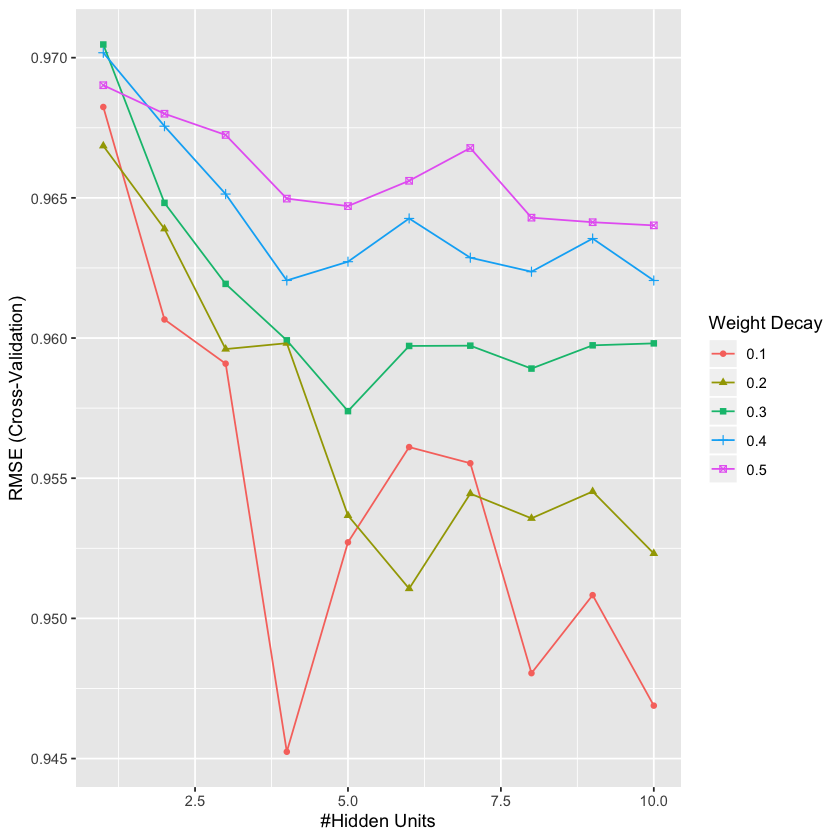

In [57]:
ggplot(nnetModel)

In [52]:
nnetModel$bestTune

,size,decay
,<dbl>,<dbl>
16,4,0.1


In [53]:
nnetModelStats <- evaluateStats(nnetModel)
nnetModelStats

$RMSE
[1] 0.752

$rSquare
[1] 0.258

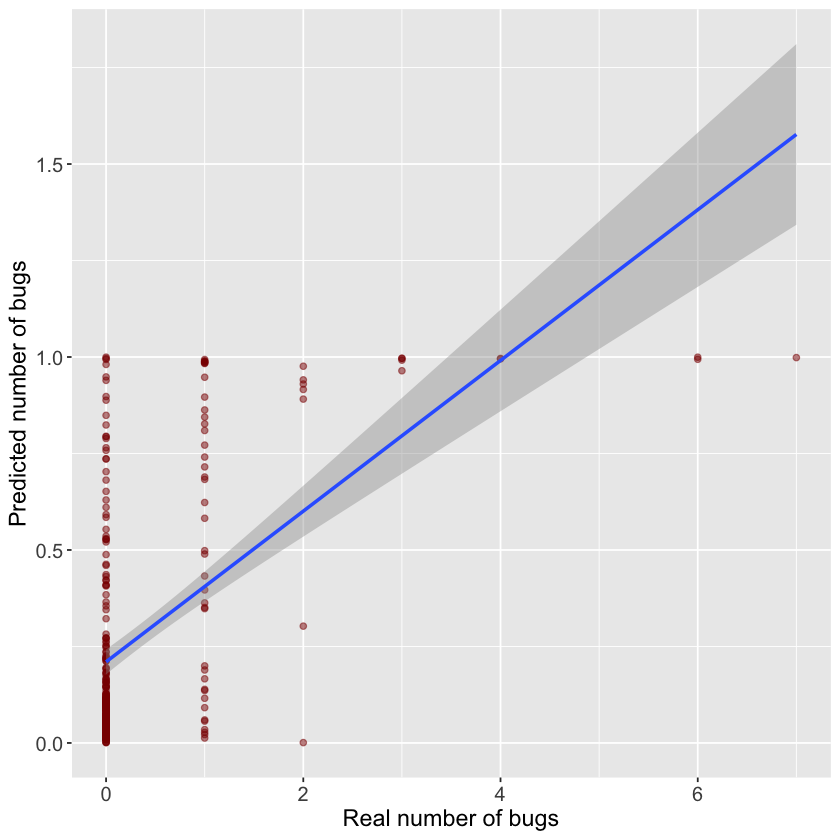

In [54]:
predictionChart(nnetModel)

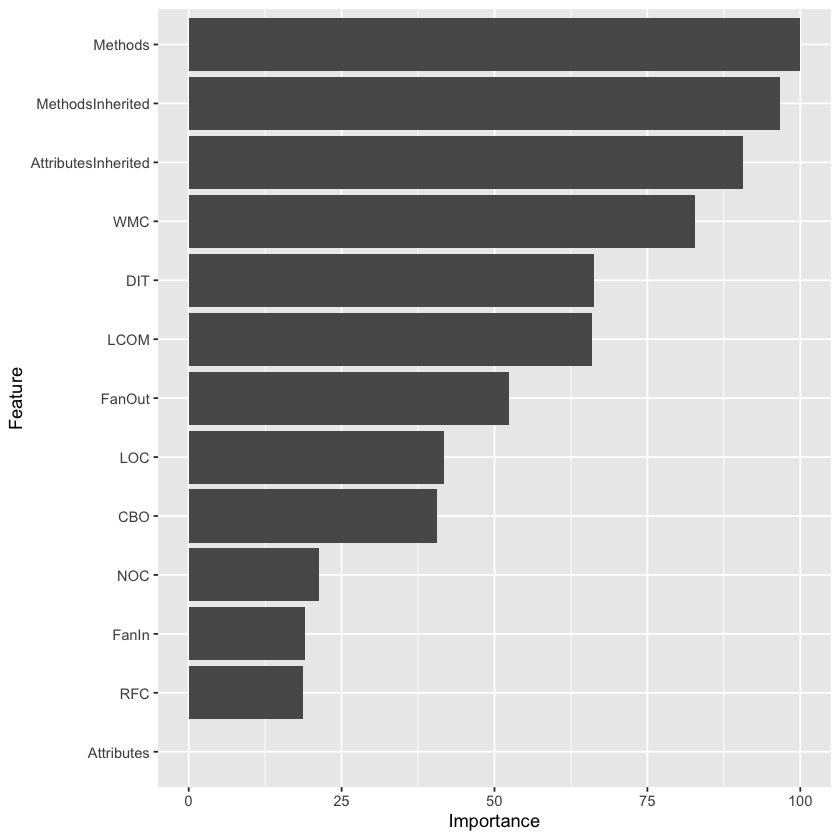

In [56]:
importancePlot(nnetModel)

# Neural Net predition using 'neuralnet' library

In [59]:
maxs <- apply(bugsData, 2, max) 
mins <- apply(bugsData, 2, min)
scaled <- as.data.frame(scale(bugsData, center = mins, scale = maxs - mins))
train_ <- scaled[inTrain,]
test_ <- scaled[-inTrain,]

In [99]:
n <- names(train_)
formula <- as.formula(paste("Bugs ~", paste(n[!n %in% "Bugs"], collapse = " + ")))
nnetModel2 <- neuralnet(formula,data=train_,hidden=c(3,2), algorithm="rprop+", linear.output=TRUE)

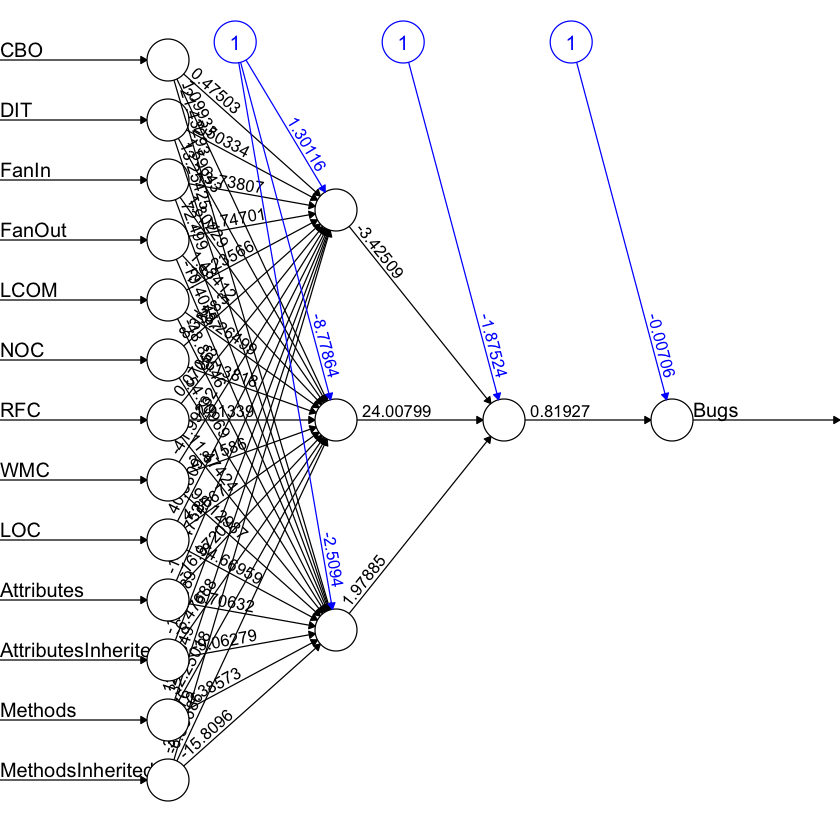

In [95]:
plot(nnetModel2, rep="best")

In [100]:
nnetModel2Stats <- evaluateStats(nnetModel2)
nnetModel2Stats

$RMSE
[1] 0.921

$rSquare
[1] -0.112

To be continued... Just some experiments.

# TODO Compare different regression models

In [101]:
compareDf <- data.frame(t(data.frame(
    knn = unlist(knnStats),
    knnPre = unlist(knnPreStats),
    rf = unlist(rfStats),
    xgb = unlist(xgbStats),
    xgbPre = unlist(xgbPreStats),
    nnetCaret = unlist(nnetModelStats),
    nnetNeuralnet = unlist(nnetModel2Stats)
)))
compareDf

,RMSE,rSquare
,<dbl>,<dbl>
knn,0.726,0.310
knnPre,0.746,0.271
rf,0.752,0.259
xgb,0.798,0.165
xgbPre,0.796,0.169
nnetCaret,0.752,0.258
nnetNeuralnet,0.921,-0.112


To be continued...